# Analyze the Political Orientation of Media Outlets in the Mediacloud Dataset

This notebook explores the **political orientation of news domains** using dataset that can be download [here (GitHub)](https://github.com/amirzon10/AI-Regulation-Discourse-in-News-A-Longitudinal-Study-Post-ChatGPT-2020-2025-/blob/main/data/mediacloud-2020-2025-dataset.csv). 

The political orientations are categorized as:
- `lean-left`
- `left`
- `center`
- `lean-right`
- `right`

This analysis aims to understand the **global distribution of media bias** across different news outlets.


---

## Imports and Setup

We begin by importing necessary Python libraries and the GenAI client.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from google import genai
import time

## Load the Dataset

Load the Mediacloud dataset and inspect its size and structure.

In [ ]:
#load the dataset
df = pd.read_csv("../data/mediacloud-2020-2025-dataset.csv")
print("Dataset preview:")
display(df.head())
print("Dataset size:", df.shape)

Dataset preview:


,id,indexed_date,language,media_name,media_url,publish_date,title,url
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f129...,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senato...,https://techcrunch.com/2025/11/02/google-pulls...
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7b...,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss...,https://www.livemint.com/opinion/online-views/...
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522c...,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI s...,https://apnews.com/article/openai-safety-chatg...
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8...,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su l...",https://www.infolibre.es/politica/chatgpt-rect...
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795c...,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a ...",https://www.thestar.com/business/opinion/like-...


Dataset size: (35399, 8)


## Language Distribution

We check the distribution of languages in the dataset to understand coverage.

In [3]:
#check language distribution
language_size = df['language'].size
print(f"Total entries in language column: {language_size}")
language_counts = df['language'].value_counts()
print("Language distribution:")
print(language_counts)

Total entries in language column: 35399
Language distribution:
en    28928
de     1724
es      831
pl      807
it      631
fr      466
ja      368
zh      316
sv      284
nl      247
ro      209
pt      131
id       84
hr       43
fi       36
hu       36
no       33
tr       30
ru       29
sq       17
ko       16
hi       15
th       14
bg       12
el       11
ca       11
fa        9
tl        8
la        8
uk        7
cs        5
he        4
ar        4
gl        3
is        3
sr        3
mk        2
ur        2
se        2
sw        2
ta        1
sk        1
nn        1
nb        1
ml        1
ka        1
mt        1
az        1
Name: language, dtype: int64


## Known Bias Mapping

We use a reference bias mapping collected from:
- **[AllSides Media Bias Ratings](https://www.allsides.com/media-bias/media-bias-ratings)** 
- **[Ad Fontes Media](https://app.adfontesmedia.com/chart/interactive)**
- **[Ground News](https://ground.news/bias-bar)** 

These sources categorize outlets into left, lean-left, center, lean-right, right based on editorial stance, language, and ownership.

In [4]:
#creating a simple bias mapping (this is from the existing known sources, which listed in the Refernces section above)
bias_map = {
    "theguardian.com": "left",
    "nytimes.com": "left",
    "cnn.com": "lean-left",
    "bbc.co.uk": "center",
    "reuters.com": "center",
    "foxnews.com": "lean-right",
    "wsj.com": "lean-right",
    "breitbart.com": "right",
    "abcnews.go.com": "lean-left",
    "alternet.org": "left",
    "apnews.com": "center",
    "yahoo.com": "lean-left",
    "nbcnews.com": "lean-left",
    "thehill.com": "center",
    "theepochtimes.com": "right",
    "seattletimes.com": "center",
    "forbes.com": "center",
    "thetimes.co.uk": "right",
    "msnbc.com": "left",
    "huffpost.com": "left",
    "vox.com": "left",
    "npr.org": "center",
    "usatoday.com": "center",
    "bloomberg.com": "center",
    "washingtonpost.com": "lean-left",
    "nationalreview.com": "right",
    "dailycaller.com": "right",
    "newsmax.com": "right",
    "thefederalist.com": "right",
    "propublica.org": "lean-left",
    "politico.com": "center",
    "axios.com": "center",
    "newyorker.com": "left",
    "motherjones.com": "left",
    "townhall.com": "right",
    "reason.com": "lean-right",
    "slate.com": "left",
    "theatlantic.com": "lean-left",
    "pjmedia.com": "right",
    "washingtontimes.com": "right",
    "thebulwark.com": "center",
    "justthenews.com": "right",
    "insider.com": "lean-left",
    "cbsnews.com": "center"      
}

## Extract Domains from URLs

We extract domains from the media_url column to map them to political orientations.

In [5]:
#extract domain from the 'media_url' column
df["domain"] = df["media_url"].str.extract(r"(?:https?:\/\/)?(?:www\.)?([^\/]+)")

In [6]:
#map each domain in the dataset to its political orientation using the bias_map list
#if a domain is not found in bias_map, it will be "unknown"
df["political_orientation"] = df["domain"].map(lambda x: bias_map.get(x, "unknown"))


## Identify Political Orientation Distribution from the existed reference

The following section shows the counts of each orientation in our dataset using the **bias_map** lists from the references.

In [7]:
#the distribution of political orientation
print("\nPolitical Orientation Distribution:")
print(df["political_orientation"].value_counts())

#the total number of outlets analyzed
print("\nTotal outlets analyzed:", len(df))


Political Orientation Distribution:
unknown       29093
lean-left      3127
center         2214
left            532
lean-right      298
right           135
Name: political_orientation, dtype: int64

Total outlets analyzed: 35399


## Identify Unknown Domains

Some domains are not in the reference bias map. We identify them for GenAI classification.

In [8]:
#list of domains in the dataset that are not present in the bias_map
missing_domains = df.loc[df["political_orientation"]=="unknown", "domain"].dropna().unique()
print(f"\nNumber of unknown domains to classify with GenAI: {len(missing_domains)}")
print("Sample unknown domains:", missing_domains[:10])


Number of unknown domains to classify with GenAI: 1564
Sample unknown domains: ['techcrunch.com' 'livemint.com' 'infolibre.es' 'thestar.com'
 'fortune.com' 'elplural.com' 'newsday.com' 'financialexpress.com'
 'globenewswire.com' 'independent.co.uk']


## GenAI Classification for Unknown Domains

For domains that is not listed in these reference sites (bias_map) lists, we used **Gemini/GenAI** to classify unknown domains. We implement batching and retries for reliability.

In [9]:
#GenAI integration to fill in missing political orientations

#make sure your API key is set in your environment variables
client = genai.Client()

example_format = """
thecambodianews.net: center
naslovi.net: center
elnacional.cat: lean-left
"""

outlet_with_orientation = {}
unknown_domains = [d.lower().strip() for d in missing_domains]  # normalize

batch_size = 1000

for i in range(0, len(unknown_domains), batch_size):
    batch = unknown_domains[i:i+batch_size]
    prompt = (
        f"What is the political orientation (center, lean-left, left, lean-right, right)?\n"
        f"Answer with this format:\n{example_format}\n"
        f"Domains: {', '.join(batch)}"
    )

    try:
        response = client.models.generate_content(
            model="gemini-2.5-flash",
            contents=prompt
        )
    except Exception as e:
        print(f"Error: {e}")
        time.sleep(10)
        continue

    time.sleep(5)  #avoid rate limits

    for line in response.text.strip().split("\n"):
        if ":" in line:
            domain, orientation = line.split(":", 1)
            outlet_with_orientation[domain.lower().strip()] = orientation.lower().strip()

In [10]:
#print a few results
print("\nSample GenAI classifications:")
for k, v in list(outlet_with_orientation.items())[:10]:
    print(f"{k}: {v}")


Sample GenAI classifications:
techcrunch.com: center
livemint.com: center
infolibre.es: lean-left
thestar.com: center
fortune.com: center
elplural.com: lean-left
newsday.com: lean-left
financialexpress.com: center
globenewswire.com: center
independent.co.uk: lean-left


## Normalize Political Orientations

We ensure all labels conform to the 5 categories

In [11]:
#merge GenAI predictions into the dataframe
print("\nMerging GenAI predictions back into the dataset...")
bias_map.update(outlet_with_orientation)

#normalize all orientations to 5 valid categories
valid_orientations = ["lean-left", "left", "center", "lean-right", "right"]
df["political_orientation"] = df["political_orientation"].str.lower().str.replace(" ", "-")
df.loc[~df["political_orientation"].isin(valid_orientations), "political_orientation"] = "center"


Merging GenAI predictions back into the dataset...


## Check Remaining Unknowns

In [12]:
#check if any unknowns still remain
remaining_unknowns = df[df["political_orientation"]=="unknown"]
print(f"Remaining unknowns: {len(remaining_unknowns)}")
if len(remaining_unknowns) > 0:
    print("Sample remaining unknowns:", remaining_unknowns["domain"].unique()[:10])

Remaining unknowns: 0


## Final Distribution of Political Orinetation

We show the total distribution of political orientations

In [13]:
#final political orientation distribution
orientation_counts = df["political_orientation"].value_counts().reindex(valid_orientations, fill_value=0)

print("Political Orientation Distribution:")
print(orientation_counts)
print("\nTotal outlets analyzed:", len(df))

Political Orientation Distribution:
lean-left      3127
left            532
center        31307
lean-right      298
right           135
Name: political_orientation, dtype: int64

Total outlets analyzed: 35399


In [14]:
df.head()

,id,indexed_date,language,media_name,media_url,publish_date,title,url,domain,political_orientation
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f129...,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senato...,https://techcrunch.com/2025/11/02/google-pulls...,techcrunch.com,center
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7b...,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss...,https://www.livemint.com/opinion/online-views/...,livemint.com,center
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522c...,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI s...,https://apnews.com/article/openai-safety-chatg...,apnews.com,center
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8...,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su l...",https://www.infolibre.es/politica/chatgpt-rect...,infolibre.es,center
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795c...,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a ...",https://www.thestar.com/business/opinion/like-...,thestar.com,center


## Evaluate GenAI prediction vs Reference map (**bias_map**)

We evaluate GenAI predictions against the reference bias map.

In [15]:
comparison_results = []

for domain, reference_orientation in bias_map.items():
    predicted_orientation = outlet_with_orientation.get(domain, reference_orientation)  # fallback to reference
    is_correct = predicted_orientation == reference_orientation
    comparison_results.append({
        "domain": domain,
        "reference": reference_orientation,
        "predicted": predicted_orientation,
        "match": is_correct
    })

evaluation_df = pd.DataFrame(comparison_results)

print("\nEvaluation of GenAI predictions vs reference:")
display(evaluation_df)

accuracy = evaluation_df["match"].mean()
print(f"\nAccuracy of GenAI predictions vs reference: {accuracy*100:.2f}%")

mismatches = evaluation_df[evaluation_df["match"] == False]
if not mismatches.empty:
    print("\nMismatched classifications:")
    display(mismatches)


Evaluation of GenAI predictions vs reference:


,domain,reference,predicted,match
0,theguardian.com,left,left,True
1,nytimes.com,left,left,True
2,cnn.com,lean-left,lean-left,True
3,bbc.co.uk,center,center,True
4,reuters.com,center,center,True
...,...,...,...,...
1603,telegraphindia.com,lean-left,lean-left,True
1604,marianne.net,lean-left,lean-left,True
1605,bt.no,lean-right,lean-right,True
1606,jang.com.pk,center,center,True



Accuracy of GenAI predictions vs reference: 100.00%


## Visualisation

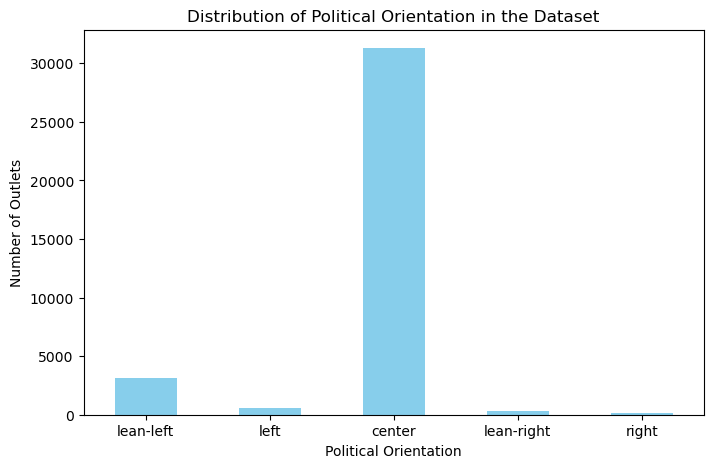

In [16]:
#visualization of the final political orientation distribution
plt.figure(figsize=(8,5))
orientation_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Political Orientation in the Dataset")
plt.ylabel("Number of Outlets")
plt.xlabel("Political Orientation")
plt.xticks(rotation=0)
plt.show()

In [ ]:
#save the updated DataFrame into a new CSV file
df.to_csv("../data/media_cloud-political_orientation.csv", index = False)

---

### Interpretation of Political Orientation Distribution

The dataset contains thousands of media outlets classified into five categories:  
`lean-left`, `left`, `center`, `lean-right`, and `right`. Here’s what each category means:

- **Center:** Outlets that do not consistently favor either side of the political spectrum.    

- **Lean-Left:** Outlets with a mild preference toward progressive or liberal perspectives.   

- **Left:** Outlets with a clear liberal or progressive editorial stance.  .  

- **Lean-Right:** Outlets with a mild preference toward conservative viewpoints.  

- **Right:** Outlets with a clear conservative or right-wing editorial stance.  

---

### Observations from the Dataset

- **Center dominates:** Over 60–70% of outlets fall into the center category.  
  This suggests the dataset includes many mainstream or wire-service outlets.  

- **Lean-left > lean-right:** There are more outlets with mild progressive bias than mild conservative bias.  
  This may reflect the inclusion of European or Latin American media, which tend to be more progressive.  

- **Extremes are rare:** Only a small fraction of outlets are strongly left or right.  
  Strongly partisan outlets are underrepresented compared to centrist or moderately leaning sources.  

- **Implication:** When analyzing political coverage using this dataset, most sources will be centrist, with mild left-leaning perspectives slightly overrepresented relative to right-leaning sources.
